# Background Theory

If some quantity, q (e.g. potential vorticity, $\xi$) can be advected by the wind field $\mathbf{v}$, then it satisfies the differential equation:

$$ \frac{Dq}{Dt} = 0 $$

We also recall from previous weeks that we can define a streamfunction, $\Psi$, for a non-divergent field.

So if we want to find the value of $q$ at some time $t^{n+1}$, we need the value of $q$ at time $t^n$ at the point in the fluid that will arrive at $\mathbf{x}_{ij}$ at time $t^{n+1}$. This is the departure point, $\tilde{\mathbf{x}}_{ij}$.

To find the departure point, we use the definition of velocity: $\frac{D \mathbf{x}}{Dt} = \mathbf{u}$.

We can integrate this over one timestep using the avergage of the values of the end points as an estmate of the value in the middle. So we have:

$$ \mathbf{x}_{ij} = \tilde{\mathbf{x}}_{ij} + \frac{\mathbf{u}\left(\tilde{\mathbf{x}}_{ij}, t^n\right) + \mathbf{u}\left(\mathbf{x}_{ij}, t^{n+1}\right)}{2} \Delta t$$

We re-arrange this for $\tilde{\mathbf{x}}_{ij}$:

$$ \tilde{\mathbf{x}}_{ij} = \mathbf{x}_{ij} - \frac{\mathbf{u}\left(\tilde{\mathbf{x}}_{ij}, t^n\right) + \mathbf{u}\left(\mathbf{x}_{ij}, t^{n+1}\right)}{2} \Delta t$$


Which we can solve iteratively.

We can use the principles above to advect a passive tracer around a 2D domain. 

The streamfunction is as originally defined in previous weeks:
$$ \Psi = \frac{\Phi_0}{f_0} \left[ 1 - A \tanh{\left(\frac{y-y_0}{L_y}\right)}\right] $$

And the passive tracer is defined as:
$$ q(x,y) = \exp \left(\frac{[(x-x_0)^2 + y-y_0)^2}{2 \sigma} \right) $$

Thus, given some domain parameters:

- $\phi_0 = 10^{5}$ metres squared per second squared
- $A = 10^{-4}$ per second
- $L_y = 5 \times 10^{5}$ metres
- $A = 0.0125 $
- $y_0 = 5 \times 10^5$ metres

We can advect a passive tracer around our 2D domain using the Semi-Lagrangian interpolation scheme.

# Solution

Imports:

In [17]:
import sys
sys.path.append('Functions') # add 'Functions' folder to system-recognised path in order to import .py file and functions from within a nested folder.

import numpy as np
import matplotlib.pyplot as plt
import scienceplots
plt.style.use('science')

from Functions.grid_interpolation import *

Define constants:

In [18]:
# constants
phi_0 = 1e5
f_0   = 1e-4
L_y   = 5e5
A     = 0.0125
sigma = 5e5
x_0   = y_0 = 2.5e6

# set up some interpolation orders for experiments
interpolation_order = 3
test_order          = 1
second_test_order   = 5

# duration of simulation
duration  = 12 * 24 * 60 * 60 # 12 days in seconds
dt        = 60 * 60 # 1 hour in seconds
num_steps = duration/dt # number of timesteps

Define the grid:

In [19]:
# common grid spacing
grid_space = 1e5

# adding 1e5 to both limits so that np.arrange() includes the upper limit
upper_x_limit = 2.5e7 + grid_space
upper_y_limit = 5e6 + grid_space

x = np.arange(0, upper_x_limit, grid_space)
y = np.arange(0, upper_y_limit, grid_space)

# define an X array where :
Y, X = np.meshgrid(y, x)

Now we can define the streamfunction and passive tracer

In [20]:
psi  = phi_0/f_0 * (1 - (A * (np.tanh((Y-y_0)/L_y))))

q_xy = np.exp(-((X-x_0)**2 + (Y-y_0)**2)/(2 * (sigma**2)))

Quick sanity check from visualisations:

$ \Psi $

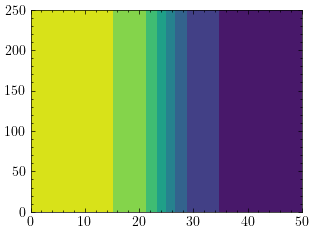

In [21]:
plt.contourf(psi)

$ q_{xy} $

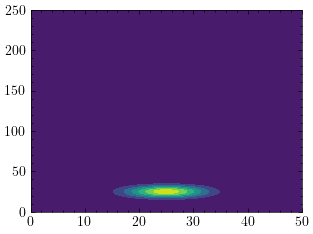

In [22]:
plt.contourf(q_xy)

Recalling the definition of the streamfunction, we have:

$$ \mathbf{v} = (u,v) = \left(-\frac{\partial \Psi}{\partial y}, \frac{\partial \Psi}{\partial x}\right) $$

Therefore, we discretise the velocity components using the centred difference scheme, giving us a zonal velocity that looks like so:

$$ u = \frac{\Psi_{j, i+1} - \Psi_{j, i-1}}{2 \Delta y} $$

For the meridional velocity we have:

$$ v = -\frac{\Psi_{j+1, i} - \Psi_{j-1, i}}{2 \Delta x} $$

We 

In [23]:
def generate_velocity(streamfunction, y, x):
    N = np.shape(y)[1]  # length in the y direction
    M = np.shape(x)[0]
    dx = dy = y[0, 1] - y[0, 0]  # extract grid space step from y array
    
    # Implement centred difference scheme for u, ignoring the boundary conditions as u 
    # is not defined on the boundary
    u = -1 * ((streamfunction[:, 2:N] - streamfunction[:, 0:(N-2)]) / (2 * dy))

    # Define boundary conditions for v
    v_first = (streamfunction[1, 1:(N-1)] - streamfunction[-1, 1:(N-1)]) / (2 * dx)
    v_last = (streamfunction[0, 1:(N-1)] - streamfunction[-2, 1:(N-1)]) / (2 * dx)

    # Implement centred difference scheme for middle values of v
    v_interior = (streamfunction[2:M, 1:(N-1)] - streamfunction[0:(M-2), 1:(N-1)]) / (2 * dx)
    
    # Combine interior and boundary values for v
    v = np.vstack([v_first, v_interior, v_last])

    return u, v

U, V = generate_velocity(psi, Y, X)

Visualising results:

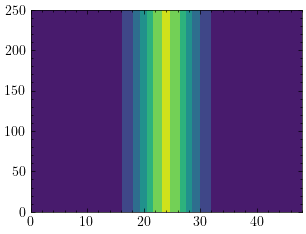

In [24]:
plt.contourf(U)

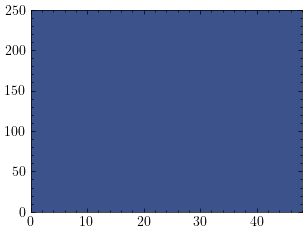

In [25]:
plt.contourf(V)

Now we can advect the passive tracer using the Semi-Lagrangian scheme. We first begin by computing the departure points.

In [26]:
def compute_dep_pts(u, v, dt, x, y, dx, max_iterations=100):

    # First we set a convergence threshold
    convergence_threshold = 0.01 * dx

    # Set an initial guess of wind at the midpoint between departure and arrival points to be the 
    # wind at the arrival point
    u_mid, v_mid = u, v

    # Set the first guess of departure points 
    x_dep = x - (u_mid * dt)
    y_dep = y - (v_mid * dt)

    # Iterate, updating departure points until convergence 
    for _ in range(max_iterations):
        # Interpolate wind to departure points using custom interpolation
        u_dep, v_dep = interpolate([u, v], x, y, x_dep, y_dep, interp_order=3, wrap=[True, False])

        # Estimate wind at midpoint
        u_mid = 0.5 * (u_dep + u)
        v_mid = 0.5 * (v_dep + v)

        # Compute new estimate departure points
        x_dep_new = x_dep - u_mid * dt
        y_dep_new = y_dep - v_mid * dt

        # Compute change from (x_dep, y_dep) to (x_dep_new, y_dep_new) across the grid
        max_change = np.max(np.sqrt((x_dep_new - x_dep)**2 + (y_dep_new - y_dep)**2))

        # Check for convergence
        if max_change < convergence_threshold * dx:
            break

        # Update departure points
        x_dep, y_dep = x_dep_new, y_dep_new

    return x_dep, y_dep

# Compute departure points
x_dep, y_dep = compute_dep_pts(u = U, v=V, dt=dt, x=X[:,1:-1], y=Y[:,1:-1], dx=grid_space)

Advect the tracer field:

In [30]:
def advect_tracer(num_steps, q, x, y, x_dep, y_dep, interp_order):

    for time_step in range(int(num_steps)):

        # Interpolate q to departure points
        q_dep = interpolate([q[:,1:-1]], x[:,1:-1], y[:,1:-1], x_dep, y_dep, interp_order=interp_order, wrap=[True, False])

        # Compute new q
        q[:,1:-1] = q_dep[0]

    return q

advected_q_interp_1 = advect_tracer(num_steps, q_xy, X, Y, x_dep, y_dep, test_order)
advected_q_interp_3 = advect_tracer(num_steps, q_xy, X, Y, x_dep, y_dep, interpolation_order)
advected_q_interp_5 = advect_tracer(num_steps, q_xy, X, Y, x_dep, y_dep, second_test_order)

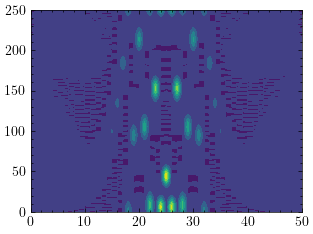

In [33]:
plt.contourf(advected_q_interp_1)

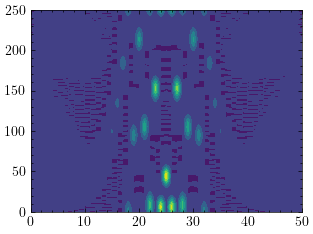

In [34]:
plt.contourf(advected_q_interp_3)

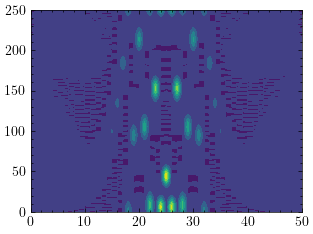

In [32]:
plt.contourf(advected_q_interp_5)